In [2]:
from osgeo import osr, ogr, gdal
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np 
import pandas as pd 
import geopandas as gpd
import rasterio
from sklearn.model_selection import train_test_split
import geopandas as gpd
from rasterio.plot import show
from geohelpers import collocate, getCoords
from osgeo import osr, ogr, gdal
import pyproj
from pyproj import Proj, transform
import geopandas as gpd
import numpy as np
import rasterio
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import math
import datetime
import geopandas as gpd
import warnings
from sklearn.preprocessing import QuantileTransformer
warnings. filterwarnings('ignore')

C:\Users\crowk\miniconda3\envs\gdal\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


goal: produce a 30m raster where each pixel is binned by some index (using a dummy rn) Use SVR (support vector regression) for continuous multi-class classification.

In [3]:
td = r"FeatureMat\tdptsreal3.shp"
scaler = QuantileTransformer(output_distribution='uniform')

td_gdf = gpd.read_file(td)

td_gdf['DEM'] = 1 - scaler.fit_transform(td_gdf['DEM'].values.reshape(-1, 1)).reshape(-1)
td_gdf['Dist2Park'] = 1 - td_gdf['parksNormD']
td_gdf = td_gdf.drop(columns=['parksNormD','CID'])
td_gdf = td_gdf.drop(columns='geometry')
td_gdf.head()


OBJECTID       DEM  CID_bin_fm  OppZones_b  TransitWei  IncomeWeig  \
0         1  0.044088           0           0    0.025143    0.009632   
1         2  0.763527           0           1    0.022502    0.009556   
2         3  0.757515           0           0    0.027255    0.009648   
3         4  0.446894           0           0    0.004543    0.009647   
4         5  0.677355           0           1    0.010564    0.009517   

   RaceWeigh  Routes_lin  TDD_lin_Cl  StlPop_30m  NLNorm_fm_  SBDs_bin_f  \
0   0.010073           0           0    0.060185    0.162864           1   
1   0.015377           0           0    0.000000    0.875790           0   
2   0.008162           0           0    0.000000    0.106773           0   
3   0.005928           0           0    0.082085    0.195063           1   
4   0.015963           1           0    0.000000    0.500616           0   

   Dist2Park  
0   0.924768  
1   0.943619  
2   0.940933  
3   0.955974  
4   0.873929

In [4]:
td_df = pd.DataFrame(td_gdf)

In [10]:
import rasterio
import numpy as np
from sklearn.preprocessing import StandardScaler

# List of raster file paths
raster_files = [
    r"FeatureMat\DEM.tif",
  #  r"FeatureMat\CID1.tif",
    r"FeatureMat\NLNorm.tif",
  #  r"FeatureMat\OppZones1.tif",
    r"FeatureMat\parksNormDist.tif",
    r"FeatureMat\StlPop.tif",
    r"FeatureMat\Routes1.tif",
  #  r"FeatureMat\SBDs.tif",
  #  r"FeatureMat\TDD.tif",
    r"FeatureMat\TransitWeigh1.tif",
    r"FeatureMat\RaceWeigh1.tif",
    r"FeatureMat\IncomeWeigh1.tif",
]
ras_ds = gdal.Open(r"FeatureMat\DEM.tif")

# Initialize an empty list to store the arrays
arrays = []

# Loop through each raster file and read it as an array
for file_path in raster_files:
    with rasterio.open(file_path, dtype='float32') as src:
        arr = src.read(1)  # Assuming you want to read the first band (index 0)
        if "StlPop" in file_path:
            arr[np.isnan(arr)] = 0
        arrays.append(arr)

# Concatenate the arrays along the third axis (axis=2) to create an nxmx10 array
feature_mat = np.stack(arrays, axis=2)
m,n,h = feature_mat.shape
'''
# Reshape the feature matrix to 2D for StandardScaler
reshaped_feature_mat = feature_mat.reshape(-1, feature_mat.shape[2])

# Initialize StandardScaler and fit_transform the reshaped feature matrix
scaler = StandardScaler()
scaled_feature_mat = scaler.fit_transform(reshaped_feature_mat)

# Reshape the scaled feature matrix back to its original shape
scaled_feature_mat = scaled_feature_mat.reshape(feature_mat.shape)

# Verify the shape and data type of the scaled feature matrix
print("Shape of the scaled feature matrix:", scaled_feature_mat.shape)
print("Data type of the scaled feature matrix:", scaled_feature_mat.dtype)
'''

'\n# Reshape the feature matrix to 2D for StandardScaler\nreshaped_feature_mat = feature_mat.reshape(-1, feature_mat.shape[2])\n\n# Initialize StandardScaler and fit_transform the reshaped feature matrix\nscaler = StandardScaler()\nscaled_feature_mat = scaler.fit_transform(reshaped_feature_mat)\n\n# Reshape the scaled feature matrix back to its original shape\nscaled_feature_mat = scaled_feature_mat.reshape(feature_mat.shape)\n\n# Verify the shape and data type of the scaled feature matrix\nprint("Shape of the scaled feature matrix:", scaled_feature_mat.shape)\nprint("Data type of the scaled feature matrix:", scaled_feature_mat.dtype)\n'

Shape of the modified array: (320, 159, 8)
Data type of the modified array: float64
Mean value of the modified array: nan


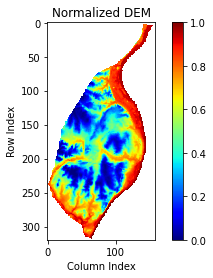

In [11]:
'''
# Normalize and invert DEM and Parks bands 
print(dem)

# Normalize the data to a 0-1 scale using QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')
nd = 1-scaler.fit_transform(dem.reshape(-1, 1)).reshape(dem.shape
'''
dem = feature_mat[:,:,0] 
demnorm = 1 - scaler.fit_transform(dem.reshape(-1, 1)).reshape(-1)
demnorm = demnorm.reshape(m,n)

parks_norm_dist_band = feature_mat[:, :, 2]
min_parks_norm_dist = parks_norm_dist_band.min()
max_parks_norm_dist = parks_norm_dist_band.max()
normalized_parks_norm_dist = 1 - ((parks_norm_dist_band - min_parks_norm_dist) / (max_parks_norm_dist - min_parks_norm_dist))

#feature_mat[:, :, 0] = nd
feature_mat[:, :, 2] = normalized_parks_norm_dist

#calculate index 

print("Shape of the modified array:", feature_mat.shape)
print("Data type of the modified array:", feature_mat.dtype)
print("Mean value of the modified array:", np.mean(feature_mat))

plt.imshow(demnorm, vmin=0, vmax=1, cmap = 'jet')  # Set vmin and vmax based on the normalized range (0 to 1)
plt.colorbar()  # Add colorbar to the plot
plt.title('Normalized DEM')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


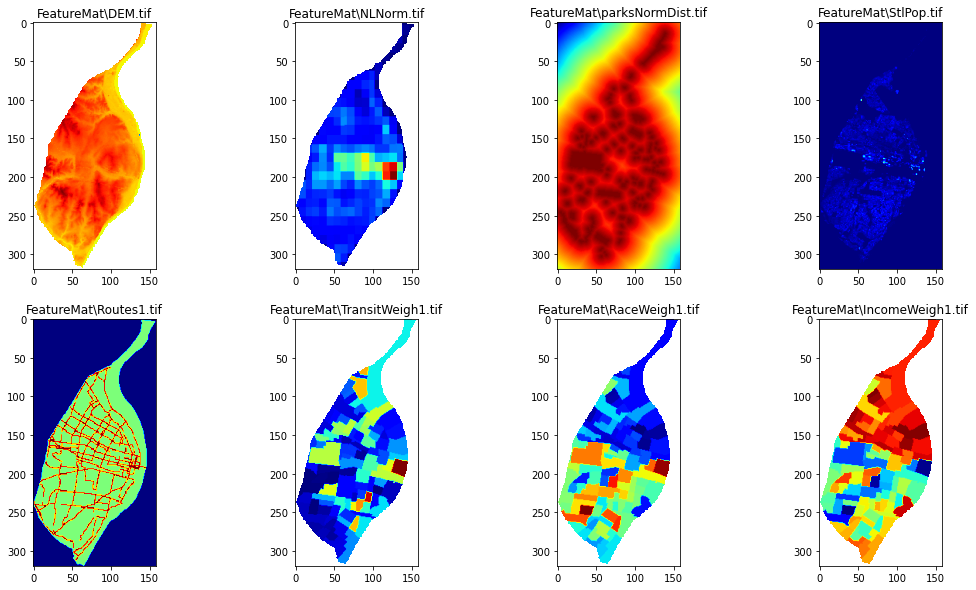

In [12]:
# Plot Classified Image 
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18,10))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = ax.flatten()
axArr = ax.flatten()
ax_index = 0

for i in range(8):
    axArr[ax_index].imshow(feature_mat[:, :, i], cmap='jet')
    axArr[ax_index].set_title(raster_files[i])
    ax_index += 1

plt.show()

In [13]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [14]:
'''for column in td_df.columns:
    # Extract the column as a numpy array and reshape it for StandardScaler
    column_data = td_df[column].values.reshape(-1, 1)
    
    # Apply StandardScaler to the column data
    scaled_column_data = scaler.fit_transform(column_data)
    
    # Update the DataFrame with the scaled data
    td_df[column] = scaled_column_data.flatten()  # Flatten to update the DataFrame
'''

'for column in td_df.columns:\n    # Extract the column as a numpy array and reshape it for StandardScaler\n    column_data = td_df[column].values.reshape(-1, 1)\n    \n    # Apply StandardScaler to the column data\n    scaled_column_data = scaler.fit_transform(column_data)\n    \n    # Update the DataFrame with the scaled data\n    td_df[column] = scaled_column_data.flatten()  # Flatten to update the DataFrame\n'

In [15]:
# calculate class labels (index)

# Extract the specified columns from td_df
selected_columns = ['IncomeWeig', 'RaceWeigh', 'TransitWei']
# Add the values of 'IncomeWeigh', 'RaceWeigh', and 'TransitWei' element-wise
sum_row = td_df[['CID_bin_fm', 'OppZones_b', 'TDD_lin_Cl','SBDs_bin_f','IncomeWeig', 'RaceWeigh', 'TransitWei']].sum(axis=1)
td_df = td_df.drop(columns = ['CID_bin_fm', 'OppZones_b', 'TDD_lin_Cl','SBDs_bin_f'])
# Append the sum row to td_df
td_df['Labels'] = sum_row.values
#td_df['Labels'] = np.ones(500)
#td_df = td_df.drop(columns = 'CZID')
# Reset the index to ensure it's continuous
td_df.reset_index(drop=True, inplace=True)

td_df.head()

OBJECTID       DEM  TransitWei  IncomeWeig  RaceWeigh  Routes_lin  \
0         1  0.044088    0.025143    0.009632   0.010073           0   
1         2  0.763527    0.022502    0.009556   0.015377           0   
2         3  0.757515    0.027255    0.009648   0.008162           0   
3         4  0.446894    0.004543    0.009647   0.005928           0   
4         5  0.677355    0.010564    0.009517   0.015963           1   

   StlPop_30m  NLNorm_fm_  Dist2Park    Labels  
0    0.060185    0.162864   0.924768  1.044848  
1    0.000000    0.875790   0.943619  1.047434  
2    0.000000    0.106773   0.940933  0.045065  
3    0.082085    0.195063   0.955974  1.020117  
4    0.000000    0.500616   0.873929  1.036043

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [17]:
# Assuming td_df is your DataFrame and 'StlPop_fm' is a column name
n_samples, n_features = td_df.shape[0], td_df.shape[1]-2
start = td_df.columns.get_loc('DEM')
X = td_df.iloc[:, start:-1]

y = td_df.iloc[:,-1]  # Class labels
display(X)
display(y)


DEM   TransitWei  IncomeWeig  RaceWeigh  Routes_lin  StlPop_30m  NLNorm_fm_  Dist2Park
0    0.044   2.514e-02     0.010      0.010         0       6.019e-02     0.163      0.925  
1    0.764   2.250e-02     0.010      0.015         0       0.000e+00     0.876      0.944  
2    0.758   2.726e-02     0.010      0.008         0       0.000e+00     0.107      0.941  
3    0.447   4.543e-03     0.010      0.006         0       8.209e-02     0.195      0.956  
4    0.677   1.056e-02     0.010      0.016         1       0.000e+00     0.501      0.874  
5    0.343   1.426e-02     0.010      0.004         0       0.000e+00     0.150      0.930  
6    0.146   3.064e-03     0.010      0.009         0       0.000e+00     0.244      0.919  
7    0.222   2.218e-02     0.010      0.018         0       0.000e+00     0.203      1.000  
8    0.754   2.218e-03     0.010      0.012         0       0.000e+00     0.000      0.988  
9    0.796   1.426e-02     0.010      0.004         0       0.000e+00     0.000      0.893  
10   1.000   5.388e-03     0.010      0.003         1       0.000e+00     0.000      0.877  
11   0.353   4.965e-03     0.010      0.017         0       0.000e+00     0.164      1.000  
12   0.417   7.817e-03     0.010      0.006         0       0.000e+00     0.550      0.947  
13   0.192   2.250e-02     0.010      0.015         0       3.793e-02     0.227      0.980  
14   0.102   4.648e-03     0.010      0.003         1       0.000e+00     0.193      0.949  
15   0.802   2.113e-03     0.010      0.009         0       3.807e-02     0.089      0.988  
16   0.240   1.806e-02     0.010      0.005         0       6.944e-03     0.241      0.975  
17   0.699   2.821e-02     0.010      0.006         0       8.273e-02     0.122      0.975  
18   0.263   4.543e-03     0.010      0.006         0       2.213e-02     0.281      0.956  
19   0.253   4.754e-03     0.010      0.012         1       6.481e-02     0.174      0.982  
20   0.896   4.965e-03     0.010      0.004         0       0.000e+00     0.123      0.887  
21   0.244   4.754e-03     0.010      0.012         0       1.039e-01     0.174      0.980  
22   0.766   3.697e-03     0.010      0.014         0       8.032e-02     0.127      0.906  
23   0.539   3.275e-03     0.010      0.007         0       0.000e+00     0.102      1.000  
24   0.552   5.282e-03     0.010      0.002         0       0.000e+00     0.177      0.938  
25   0.928   1.025e-02     0.010      0.009         0       0.000e+00     0.151      0.917  
26   0.816   1.373e-03     0.010      0.007         0       2.793e-02     0.114      0.982  
27   0.535   6.867e-03     0.010      0.006         0       2.546e-01     0.239      0.975  
28   0.509   1.056e-02     0.010      0.016         0       1.328e-02     0.420      0.902  
29   0.501   4.543e-03     0.010      0.006         0       1.524e-04     0.195      0.947  
30   0.475   2.430e-03     0.009      0.019         1       5.324e-02     0.125      0.982  
31   0.168   2.218e-03     0.010      0.011         1       3.009e-02     0.206      0.991  
32   0.226   1.373e-02     0.010      0.012         0       5.922e-02     0.134      0.972  
33   0.383   3.064e-03     0.010      0.009         1       7.630e-02     0.210      0.975  
34   0.058   3.064e-03     0.010      0.009         0       0.000e+00     0.193      0.924  
35   0.339   2.081e-02     0.010      0.004         1       2.310e-02     0.118      0.953  
36   0.469   6.867e-03     0.010      0.006         1       3.379e-02     0.206      0.938  
37   0.653   1.268e-03     0.009      0.023         0       6.586e-02     0.149      0.894  
38   0.858   1.426e-02     0.010      0.004         0       0.000e+00     0.080      0.913  
39   0.697   1.479e-03     0.010      0.010         1       6.340e-02     0.125      0.947  
40   0.691   1.479e-03     0.010      0.010         0       5.920e-02     0.112      0.941  
41   0.912   1.426e-02     0.010      0.004         0       3.111e-05     0.080      0.846  
42   0.

0      1.045
1      1.047
2      0.045
3      1.020
4      1.036
5      1.028
6      1.022
7      0.050
8      0.024
9      1.028
10     0.019
11     0.032
12     2.023
13     1.047
14     1.018
15     0.021
16     1.033
17     0.044
18     1.020
19     0.027
20     1.019
21     0.027
22     0.027
23     0.020
24     1.017
25     1.029
26     0.018
27     1.022
28     2.036
29     1.020
30     0.031
31     0.023
32     0.035
33     1.022
34     1.022
35     0.035
36     0.022
37     0.034
38     1.028
39     0.021
40     0.021
41     1.028
42     0.050
43     0.021
44     0.022
45     0.030
46     0.020
47     1.036
48     1.028
49     1.022
50     0.015
51     0.032
52     1.017
53     1.029
54     0.026
55     1.028
56     0.031
57     0.031
58     0.035
59     1.022
60     2.041
61     1.028
62     0.030
63     1.053
64     0.027
65     0.022
66     0.045
67     0.050
68     0.053
69     0.040
70     0.050
71     1.029
72     0.027
73     1.028
74     0.034
75     0.034
76     1.017

In [18]:
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr = SVR()

# Define the grid of hyperparameters to search
param_grid = {
    "kernel": ["rbf"],
    "C": [1,10,10,100,1000],
    "gamma": [1e-12,1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }

# Initialize GridSearchCV with the SVR regressor and hyperparameter grid
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=10)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set using mean squared error (MSE)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(y_pred)

print("Best hyperparameters:", best_params)
print("Mean Squared Error on test set:", mse)


[ 0.19543537  0.94007483  0.60330136 -0.00557323  0.2304962   0.20628553
  0.07351667  1.04299972  0.31919614  0.43440306  0.71960386  0.14045749
  0.29462153  0.17901943  0.62321495  0.43398657  0.09245812 -0.05713099
  0.69130484  0.92890593  1.07118058  0.17253424  0.01341223  1.27971446
  0.21139176  0.88402866  0.61481267  0.6863171   0.41631578  0.0025653
  0.33894397  0.31510736 -0.01950088  0.37308038  0.66627736  1.01982929
  0.78466684  0.33991887  0.0590087   1.02930787  0.72366575  0.22519564
  0.4046319  -0.01924568  0.07326093  0.08120357  0.13967438  0.07229833
  0.34748361  0.53289629  0.55229157  0.14608256  0.28993203  0.27630014
  0.22078304  0.75994777  0.89465127  0.27729323 -0.00820674  0.05672574
  0.4654817   1.13895542  0.17267021  0.14263552  1.01781765  0.15609998
  0.78614562  0.74252574  0.77199765  0.07764235  0.15227406  0.11888929
  0.41673119  0.25915366  0.35898492  0.31258243  0.36575101  0.24007949
  0.66622408 -0.05500959  0.45896654  0.00764419 -0.

In [19]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, gamma = 1e-8, kernel = 'rbf'))
regr.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2, gamma=1e-08))])

Text(0.5, 0, 'Permutation Importance')

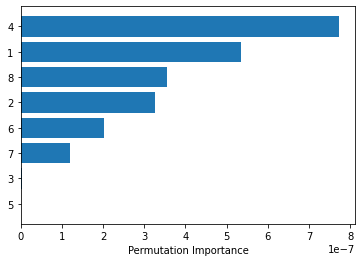

In [32]:
# perform permutation importance
from sklearn.inspection import permutation_importance

importance = permutation_importance(regr, X, y, scoring='neg_mean_squared_error')

feature_names = ['1', '2', '3', '4','5','6','7','8']
features = np.array(feature_names)

sorted_idx = importance.importances_mean.argsort()
plt.barh(features[sorted_idx], importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [21]:
m,n, h = feature_mat.shape
print('m: ',m,'n: ',n,'h: ',h)

m:  320 n:  159 h:  8


In [22]:
feature_mat_flat = feature_mat.reshape(m*n,h)
featdf = pd.DataFrame(feature_mat_flat)
#display(featdf)

In [23]:
import time
import numpy as np

start_time = time.time()  # Start timing

# Define batch size
batch_size = 100

print(feature_mat_flat.shape)
i = 0
assignments = []

for pix in feature_mat_flat:
  #  print(pix)
    if np.isnan(pix).any():  # Check if any NaN values are present
        pred = -1
    else:
        pred = regr.predict(pix.reshape(1, -1))
    
    assignments.append(pred)

    if i % 1000 == 0:
        # print(pix)
        print('pix:', i, 'prediction:', pred)
    
    i += 1
    
# End timing
end_time = time.time()
execution_time = end_time - start_time


(50880, 8)
pix: 0 prediction: -1
pix: 1000 prediction: -1
pix: 2000 prediction: -1
pix: 3000 prediction: [0.24098504]
pix: 4000 prediction: -1
pix: 5000 prediction: -1
pix: 6000 prediction: -1
pix: 7000 prediction: -1
pix: 8000 prediction: -1
pix: 9000 prediction: -1
pix: 10000 prediction: -1
pix: 11000 prediction: -1
pix: 12000 prediction: [0.24110669]
pix: 13000 prediction: -1
pix: 14000 prediction: -1
pix: 15000 prediction: -1
pix: 16000 prediction: [0.24100086]
pix: 17000 prediction: -1
pix: 18000 prediction: -1
pix: 19000 prediction: [0.24106397]
pix: 20000 prediction: [0.24095162]
pix: 21000 prediction: -1
pix: 22000 prediction: [0.24118507]
pix: 23000 prediction: [0.24113925]
pix: 24000 prediction: -1
pix: 25000 prediction: [0.241118]
pix: 26000 prediction: [0.24114937]
pix: 27000 prediction: [0.24108406]
pix: 28000 prediction: -1
pix: 29000 prediction: [0.24122866]
pix: 30000 prediction: [0.24127133]
pix: 31000 prediction: -1
pix: 32000 prediction: [0.24107251]
pix: 33000 predi

In [24]:
print(f"Execution time: {execution_time} seconds")

Execution time: 25.699618816375732 seconds


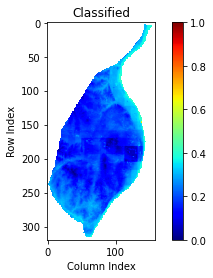

In [25]:
assignments_fixed = []

# Iterate through the predictions
for pred in assignments:
    if isinstance(pred, list):  # Check if pred is a list or array
        assignments_fixed.extend(pred)  # Unpack the list and append its elements
    elif pred == -1:
        assignments_fixed.append(np.nan)  # Replace -1 with NaN
    else:
        assignments_fixed.append(pred)  # Keep the value unchanged

assignmentsArr = np.array(assignments_fixed, dtype='object')
lc = assignmentsArr.reshape(m, n)
min2 = np.nanmin(lc)
max2 = np.nanmax(lc)
lc_norm = 1 - ((lc - min2) / (max2 - min2))

#normalize classified image 
lc_float = lc_norm.astype(float)
img_class = plt.imshow(lc_float, cmap='jet')
plt.title('Classified')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.colorbar(img_class)
plt.show()

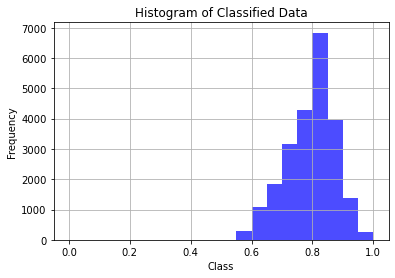

In [26]:
# Flatten the 2D array lc to a 1D array
lc_flattened = lc_float.flatten()
min1 = np.nanmin(lc_flattened)
max1 = np.nanmax(lc_flattened)
lc_norm = 1 - ((lc_flattened - min1) / (max1 - min1))

# Plot histogram
plt.hist(lc_norm, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Classified Data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [27]:
#function to write array to tiff
def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)  # Create a 2D image
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_ds.GetRasterBand(1).WriteArray(arr)  # Write the 2D image data to the GeoTIFF
    out_ds.FlushCache()
    out_ds = None  # Close the dataset to save changes

In [28]:
#function to 
write_geotiff("data\Classified1.tif", lc_float, ras_ds)   
